## Analisis de los datos que tenemos

### Resultados de las partidas
Gráfico de barras con la cantidad de partidas ganadas por blancos, negros y tablas.
Relación entre diferencia de Elo y el resultado de la partida.

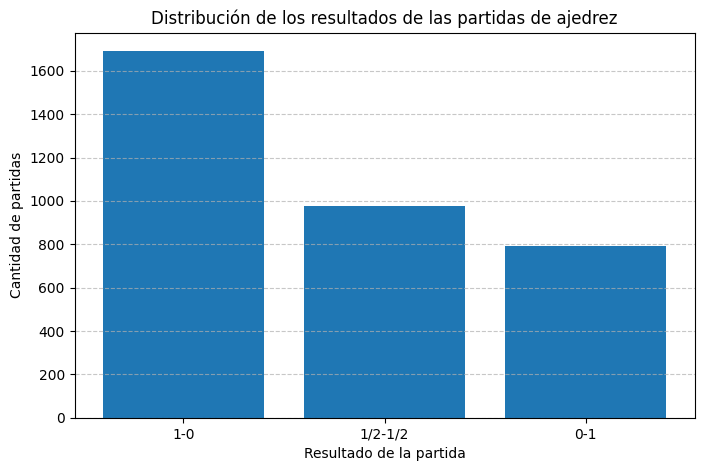

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Cargar el archivo CSV
df_games = pd.read_csv("../data/games.csv")
df_openings = pd.read_csv("../data/openings.csv")

# Contar la cantidad de cada resultado
result_counts = df_games["Result"].value_counts()

# Graficar los resultados
plt.figure(figsize=(8, 5))
plt.bar(result_counts.index, result_counts.values)
plt.xlabel("Resultado de la partida")
plt.ylabel("Cantidad de partidas")
plt.title("Distribución de los resultados de las partidas de ajedrez")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar la gráfica
plt.show()


### Aperturas más jugadas
Gráfico de barras con las aperturas más comunes en las partidas.
Análisis del resultado promedio para cada apertura.

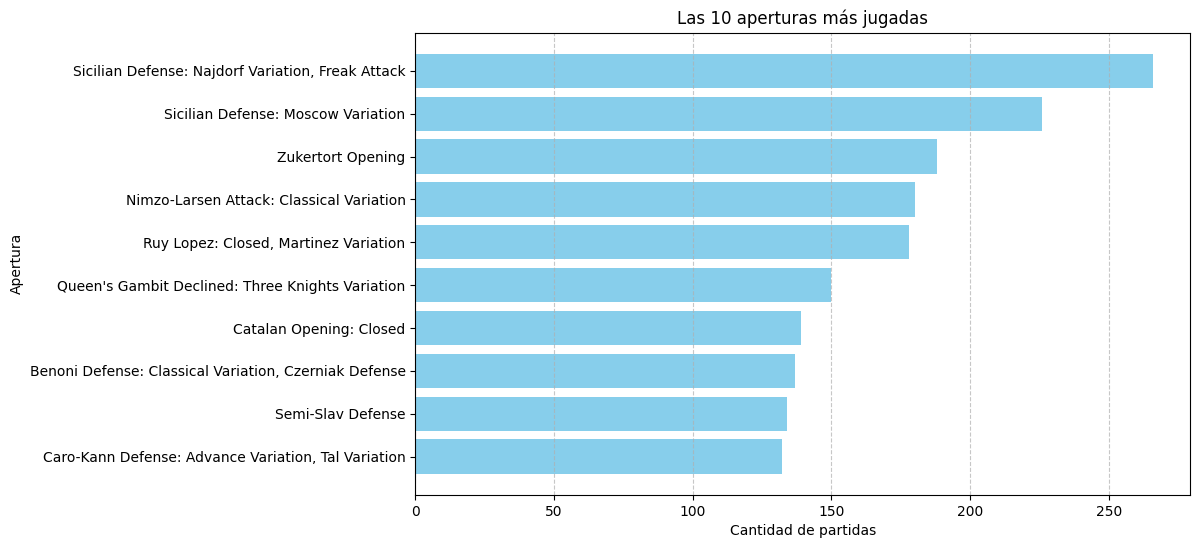

In [4]:
# Contar las aperturas más jugadas
opening_counts = df_games["ECO"].value_counts().head(10)  # Tomamos las 10 más frecuentes

# Mapear los códigos ECO a los nombres de apertura usando el dataset de aperturas
opening_names = df_openings.set_index("ECO")["Opening"].to_dict()
opening_labels = [opening_names.get(eco, eco) for eco in opening_counts.index]

# Graficar las aperturas más jugadas
plt.figure(figsize=(10, 6))
plt.barh(opening_labels, opening_counts.values, color="skyblue")
plt.xlabel("Cantidad de partidas")
plt.ylabel("Apertura")
plt.title("Las 10 aperturas más jugadas")
plt.gca().invert_yaxis()  # Invertimos el eje para que la más jugada aparezca arriba
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Mostrar la gráfica
plt.show()


### Evaluación de las jugadas
Evolución promedio de la evaluación a lo largo de los movimientos en partidas.
Comparación entre la evaluación media para jugadores con Elo alto vs. bajo

### Duración de las partidas
Distribución de los tiempos registrados en las partidas.


### Frecuencia de movimientos
Cuáles son los movimientos más jugados en las primeras jugadas